In [157]:
import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Warnings configuration
import warnings

In [209]:
data = pd.read_csv('C:\\Users\\John\\Documents\\Berkeley\\Classwork\\group project\\data\\Albert_cleaned_sets\\mega_merged.csv', index_col=0)

In [216]:
# Data preparation
# ==============================================================================

# Dropping first 7 rows being country summation.
data = data.iloc[7:]

# Label Encoding
le = LabelEncoder()
data.State = le.fit_transform(data.State)

# Specifying datetime column for index
data['Year'] = pd.to_datetime(data['Year'], format='%Y')

#data = data.set_index('Year')
data = data.asfreq(pd.DateOffset(years=1))
data = data.sort_index()
data.head()

C:\Users\John\AppData\Local\Temp\ipykernel_15944\1027823405.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.State = le.fit_transform(data.State)


ValueError: unconverted data remains: -01-01T00:00:00

In [201]:
var1 = "2022-10-09"
from datetime import datetime, date
# from time import strftime, strptime

datstr = datetime(datetime.strptime(var1).isoformat())
datstr

AttributeError: 'str' object has no attribute 'isoformat'

In [208]:
datetime.strptime(var1, "%Y-%m-%d").isoformat()

'2022-10-09T00:00:00'

In [214]:
data['Year'] = pd.to_datetime(data['Year'], format='%Y-%m-%d')
data['Year'] = data['Year'].astype(str)
data['Year'] = data['Year'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").isoformat())
data['Year']

0      2014-01-01T00:00:00
1      2015-01-01T00:00:00
2      2016-01-01T00:00:00
3      2017-01-01T00:00:00
4      2018-01-01T00:00:00
              ...         
349    2016-01-01T00:00:00
350    2017-01-01T00:00:00
351    2018-01-01T00:00:00
352    2019-01-01T00:00:00
353    2020-01-01T00:00:00
Name: Year, Length: 354, dtype: object

In [140]:
data.dtypes

State                         int32
Population                    int64
Number of Cannabis Users      int64
Number of Opioid Deaths       int64
Per Capita Cannabis Use     float64
Per Capita Opioid Deaths    float64
Recreational                  int64
Rec Year Legalized            int64
Medical                       int64
Med Year Legalized            int64
Years legal (rec)             int64
Years legal (med)             int64
dtype: object

In [141]:
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


In [142]:
# Split data into train-test
steps = 51
data_train = data[:-steps]
data_test  = data[-steps:]

In [143]:
print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates : 2014-01-01 00:00:00 --- 2019-01-01 00:00:00  (n=296)
Test dates  : 2020-01-01 00:00:00 --- 2020-01-01 00:00:00  (n=51)


In [160]:
data_train.head()

,State,Population,Number of Cannabis Users,Number of Opioid Deaths,Per Capita Cannabis Use,Per Capita Opioid Deaths,Recreational,Rec Year Legalized,Medical,Med Year Legalized,Years legal (rec),Years legal (med)
Year,,,,,,,,,,,,
2014-01-01,34,738736,62000,43,0.083927,0.000058,0,0,1,2016,0,6
2014-01-01,25,6059130,639000,1067,0.105461,0.000176,0,0,1,2018,0,4
2014-01-01,16,2901861,259000,332,0.089253,0.000114,0,0,0,0,0,0
2014-01-01,18,4645938,425000,777,0.091478,0.000167,0,0,1,2015,0,7
2014-01-01,37,3965447,649000,522,0.163664,0.000132,1,2014,1,1998,8,24


In [163]:
Stateslist = data_train['State'].unique()
len(Stateslist)

51

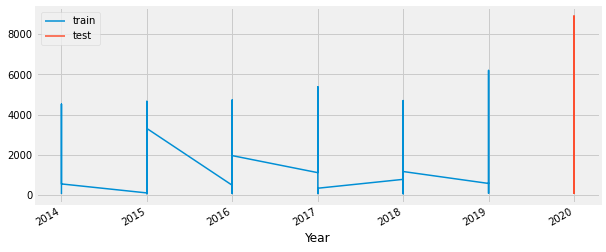

In [144]:
fig, ax=plt.subplots(figsize=(9, 4))
data_train['Number of Opioid Deaths'].plot(ax=ax, label='train')
data_test['Number of Opioid Deaths'].plot(ax=ax, label='test')
ax.legend();

In [170]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 5
             )

#forecaster.fit(y=data_train['Number of Opioid Deaths'])
#forecaster

In [177]:
for i in Stateslist[0:2]:
    filterdf = data_train[data_train['State'] == i]
    filterdf = filterdf.asfreq('A')
    forecaster.fit(y=filterdf['Number of Opioid Deaths'])


Exception: `y` has missing values.

In [172]:
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5] 
Transformer for y: None 
Transformer for exog: None 
Window size: 5 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 5] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-11-09 20:28:29 
Last fit date: 2022-11-09 20:28:31 
Skforecast version: 0.5.1 
Python version: 3.10.0 

In [174]:
# Predictions
steps = 51
predictions = forecaster.predict(steps=steps)
predictions.head(5)

C:\Users\John\AppData\Roaming\Python\Python310\site-packages\skforecast\utils\utils.py:417: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


5    1583.0
6    1583.0
7    1583.0
8    1583.0
9    1583.0
Name: pred, dtype: float64

In [150]:
predictions

6     1247.76
7      996.89
8     1567.41
9      601.47
10     832.01
11    1191.19
12     979.24
13    1132.56
14    1102.74
15     801.78
16     952.58
17     798.10
18     979.08
19    1121.33
20     917.11
21     962.90
22     867.03
23     787.64
24     928.47
25     932.36
26    1191.92
27    1433.69
28     766.22
29     849.14
30    1025.41
31    1062.36
32     930.03
33    1173.73
34     810.89
35     759.24
36     917.91
37     874.59
38    1195.80
39    1365.22
40     699.09
41     966.94
42     928.19
43    1079.67
44    1074.03
45     835.59
46     735.85
47     810.91
48     825.99
49    1097.71
50    1270.18
51     995.21
52     988.08
53     996.07
54     970.91
55     794.30
56     871.33
Name: pred, dtype: float64

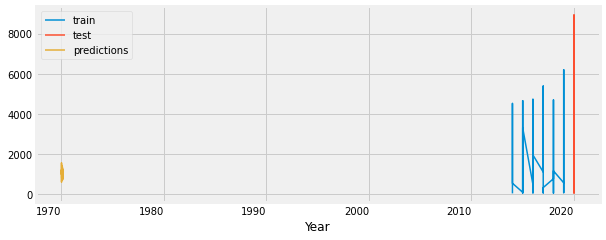

In [147]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['Number of Opioid Deaths'].plot(ax=ax, label='train')
data_test['Number of Opioid Deaths'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [148]:
# Test error
error_mse = mean_squared_error(
                y_true = data_test['Number of Opioid Deaths'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 4157659.6776176468


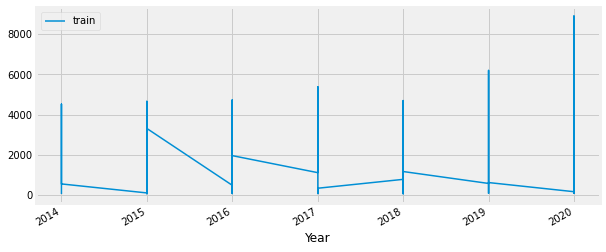

In [149]:
fig, ax=plt.subplots(figsize=(9, 4))
data['Number of Opioid Deaths'].plot(ax=ax, label='train')
ax.legend();